# Normalize L1C scenes radiometrically

Each EO-product should include a **pre-processing step** in the beginning for masking out clouds, radiometric corrections and in order to avoid unnecessary artefacts in the final product. One of the most basic pre-processing methods is a radiometric adjustment in order to obtain the Bottom-Of-Atmosphere reflectance.

In contrast to this absolute radiometric correction which is often done using Sen2cor, also a relative radiometric normalization can be done. This approach normalizes an image on a temporal basis by analyzing a time-series. As a result, influences of recorded reflectances such as the sun's azimuth angle, elevation and atmospheric conditions can be rectified to a certain extent.

Using the `eo-learn` library of Sentinel Hub simplifies this approach significantly. For an AOI and time interval of choice, Sentinel-2 data will be downloaded in form of an `EOPatch`. This `EOPatch` gets manipulated in a sequence of `EOTasks` chained in an `EOWorkflow`.

---

In this example the final workflow to radiometrically normalize Sentinel-2 scenes is a sequence of the following tasks:
1. Create an `EOPatch` by filling it with L1C data including every band
2. Validate pixels using Sen2Cor's scene classification map
3. Calculate coverage of valid pixels
4. Mask the `EOPatch` with the valid data mask
5. Select scenes with highest fraction of valid pixels as reference scenes
6. Create a composite of the reference scenes
7. Remove temporary EOPatch layers
8. Perform a histogram match


**Contributor:**  
_Johannes Schmid  
[GeoVille Information Systems GmbH](www.geoville.com)  
2018_  

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Create-EOTasks" data-toc-modified-id="1.-Create-EOTasks-1">1. Create EOTasks</a></span></li><li><span><a href="#2.-Initialize-EO-Tasks" data-toc-modified-id="2.-Initialize-EO-Tasks-2">2. Initialize EO-Tasks</a></span></li><li><span><a href="#3.-Define-and-execute-Workflow" data-toc-modified-id="3.-Define-and-execute-Workflow-3">3. Define and execute Workflow</a></span></li><li><span><a href="#4.-Results" data-toc-modified-id="4.-Results-4">4. Results</a></span></li><li><span><a href="#4.1-Comparison-on-an-index" data-toc-modified-id="4.1-Comparison-on-an-index-5">4.1 Comparison on an index</a></span></li></ul></div>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from rasterio.plot import show_hist

from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, RemoveFeature
from eolearn.io import SentinelHubInputTask
from eolearn.features import ReferenceScenes, HistogramMatching, BlueCompositing, \
    MaxNDVICompositing, MaxNDWICompositing, MaxRatioCompositing, HOTCompositing
from eolearn.mask import AddValidDataMaskTask, MaskFeature

from sentinelhub import BBox, CRS, MimeType, DataCollection

## 1. Create EOTasks

In [3]:
class ValidDataCoverageTask(EOTask):
    """
    Tasks determines the fraction of non-zero pixels in user specified MASK and adds it to EOPatch's scalar feature.
    """
    def __init__(self, scalar_feature, mask_feature):
        self.scalar_feature = next(self._parse_features(scalar_feature, default_feature_type=FeatureType.SCALAR)())
        self.mask_feature = next(self._parse_features(mask_feature, default_feature_type=FeatureType.MASK)())
        
    def execute(self, eopatch):
        valid_mask = eopatch[self.mask_feature]
        valid_cov = np.count_nonzero(valid_mask, axis=(1,2))/np.prod(valid_mask.shape[1:])
                
        eopatch[self.scalar_feature] = valid_cov
        return eopatch

In [4]:
# this function merges the `IS_DATA` and the `CLM` masks
class ValidDataPredicate:
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask['dataMask'].astype(np.bool), 
                              np.logical_not((eopatch.mask['CLM'] != 0).astype(np.bool)))

## 2. Initialize EO-Tasks

In [5]:
# 1. Create an `EOPatch` by filling it with L1C data including every band
input_task = SentinelHubInputTask(
    data_collection = DataCollection.SENTINEL2_L1C, 
    bands_feature=(FeatureType.DATA, 'BANDS-S2-L1C'),
    bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12'],
    time_difference = timedelta(hours=2),
    resolution=20,
    additional_data = [
        (FeatureType.MASK, 'CLM'),
        (FeatureType.MASK, 'dataMask'),
    ]
)

# 2. Add valid data mask
add_valmask_task = AddValidDataMaskTask(predicate=ValidDataPredicate(), 
                                        valid_data_feature = (FeatureType.MASK, 'VALID_DATA'))

# 5. Calculate fraction of valid pixels
add_coverage = ValidDataCoverageTask('VALID_COV', 'VALID_DATA')

# 6. Mask EOPatch with SCL
mask_input = MaskFeature((FeatureType.DATA, 'BANDS-S2-L1C', 'MASKED'), 
                         (FeatureType.MASK, 'CLM'), 
                         mask_values=[1,255])

# 7. Select min. 5 scenes with highest fraction of valid pixels as reference scenes
add_reference_scenes = ReferenceScenes((FeatureType.DATA, 'MASKED', 'REFERENCE_SCENES'), 
                                       (FeatureType.SCALAR, 'VALID_COV'),  
                                       max_scene_number=5)

# 8. Composite of reference scenes - select one of the following methods
composite = BlueCompositing((FeatureType.DATA, 'REFERENCE_SCENES'), 
                            (FeatureType.DATA_TIMELESS, 'REFERENCE_COMPOSITE'), 
                            blue_idx=0, interpolation='geoville')
# composite = MaxNDVICompositing((FeatureType.DATA, 'REFERENCE_SCENES'), 
#                                (FeatureType.DATA_TIMELESS, 'REFERENCE_COMPOSITE'), 
#                                red_idx=2, nir_idx=7, interpolation='geoville')
# composite = MaxNDWICompositing((FeatureType.DATA, 'REFERENCE_SCENES'), 
#                                (FeatureType.DATA_TIMELESS, 'REFERENCE_COMPOSITE'), 
#                                nir_idx=6, swir1_idx=8, interpolation='geoville')
# composite = HOTCompositing((FeatureType.DATA, 'REFERENCE_SCENES'), 
#                            (FeatureType.DATA_TIMELESS, 'REFERENCE_COMPOSITE'), 
#                            blue_idx=0, red_idx=2, interpolation='geoville')
# composite = MaxRatioCompositing((FeatureType.DATA, 'REFERENCE_SCENES'), 
#                                 (FeatureType.DATA_TIMELESS, 'REFERENCE_COMPOSITE'), 
#                                 blue_idx=0, nir_idx=6, swir1_idx=8, interpolation='geoville')

# 9. Histogram Match
histogram_match = HistogramMatching((FeatureType.DATA, 'MASKED', 'RADIOMETRIC_NORMALISED'), 
                                    (FeatureType.DATA_TIMELESS, 'REFERENCE_COMPOSITE')) 

## 3. Define and execute Workflow

In [6]:
# For optimal results, use a period of three month (12,1,2 - 3,4,5 - 6,7,8 - 9,10,11)
time_interval = ['2017-06-01','2017-08-31'] 

# Choose your AOI and create a bbox-object
bounds = [16.53,47.83,16.63,47.93] # smaller AOI, can be run on laptop
bbox = BBox(bbox=bounds, crs=CRS.WGS84)

In [7]:
workflow = LinearWorkflow(
    input_task, 
    add_valmask_task,
    add_coverage, 
    mask_input, 
    add_reference_scenes,
    composite,
    histogram_match
)

results = workflow.execute({input_task:{'bbox':bbox, 'time_interval':time_interval}})

## 4. Results

In [8]:
eop = results.eopatch()
eop

EOPatch(
  data: {
    BANDS-S2-L1C: numpy.ndarray(shape=(30, 563, 362, 10), dtype=float32)
    MASKED: numpy.ndarray(shape=(30, 563, 362, 10), dtype=float32)
    RADIOMETRIC_NORMALISED: numpy.ndarray(shape=(30, 563, 362, 10), dtype=float32)
    REFERENCE_SCENES: numpy.ndarray(shape=(5, 563, 362, 10), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(30, 563, 362, 1), dtype=uint8)
    VALID_DATA: numpy.ndarray(shape=(30, 563, 362, 1), dtype=bool)
    dataMask: numpy.ndarray(shape=(30, 563, 362, 1), dtype=bool)
  }
  scalar: {
    VALID_COV: numpy.ndarray(shape=(30, 1), dtype=float64)
  }
  label: {}
  vector: {}
  data_timeless: {
    REFERENCE_COMPOSITE: numpy.ndarray(shape=(563, 362, 10), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 1.0
    service_type: 'processing'
    size_x: 362
    size_y: 563
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: ('2017-06-01T00:00:00

You can see a slight difference of the values

In [9]:
ts_idx = 2
example_input_scene = eop.data['MASKED'][ts_idx]
example_output_scene = eop.data['RADIOMETRIC_NORMALISED'][ts_idx]

print("L1C/Radiometric Normalized")
print(f'mean: {np.nanmean(example_input_scene[:,:,0]):.3f}/{np.nanmean(example_output_scene[:,:,0]):.3f}')
print(f'std: {np.nanstd(example_input_scene[:,:,0]):.3f}/{np.nanstd(example_output_scene[:,:,0]):.3f}')

L1C/Radiometric Normalized
mean: 0.107/0.093
std: 0.017/0.016


Lets plot a subset of the first three bands (RGB) of the selected input scene (left) and output scene (right) as an example

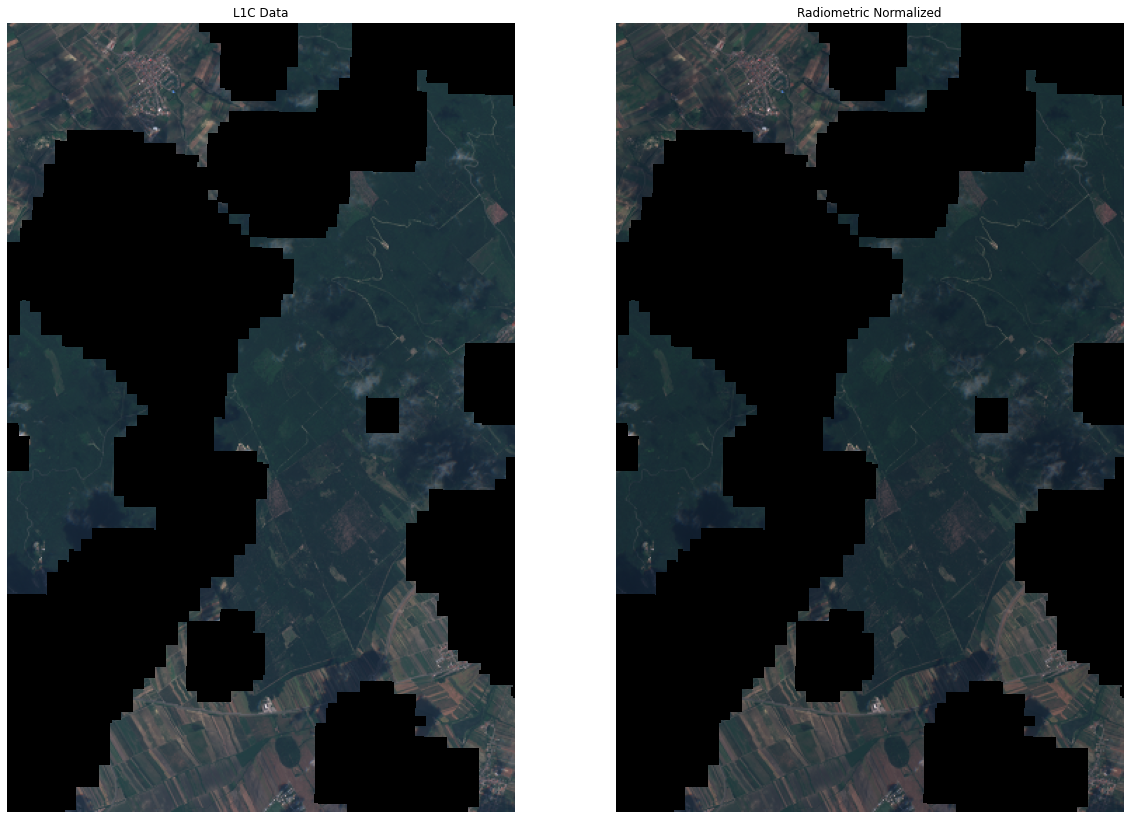

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,20))

ax = axs[0]
ax.imshow(np.clip(example_input_scene[..., [2,1,0]]*2.5, 0, 1))
ax.set_title("L1C Data")
ax.set_axis_off()

ax = axs[1]
ax.imshow(np.clip(example_output_scene[..., [2,1,0]]*2.5, 0, 1))
ax.set_title("Radiometric Normalized")
ax.set_axis_off()

## 4.1 Comparison on an index

In contrast to the previously displayed RGB images, an index might be able to show the influence of the radiometric normalization better.  
  
The index Tasseled Cap includes three bands: "brightness", "greenness" and "wetness". The advantage of this index is the consideration of all satellite bands. Similar to the Principle Component Analysis, the most valueable information is kept and summarized while using less data memory.

In [11]:
def tasseled_cap_index_for_sentinel2(bands):
    """
    Contributor: Johannes Schmid, GeoVille Information Systems GmbH, 2018
    Tasseled Cap index adjusted to Sentinel-2 data after
    Nedkov, R. (2017): Orthogonal transformation of segmented images from the satellite Sentinel-2.
    In: Comptes rendus de l'Académie bulgare des sciences 70., p. 687-692.
    The index was renormalized due to the missing bands 1, 9 and 10.
    """
    BLUE = bands[:,:,0]    # B02
    GREEN = bands[:,:,1]   # B03
    RED = bands[:,:,2]     # B04
    RE1 = bands[:,:,3]     # B05
    RE2 = bands[:,:,4]     # B06
    RE3 = bands[:,:,5]     # B07
    NIR = bands[:,:,6]     # B08
    NIR2 = bands[:,:,7]    # B8A
    SWIR1 = bands[:,:,8]   # B11
    SWIR2 = bands[:,:,9]   # B12
    
    brightness = 8.262635e-02 * BLUE + 1.367054e-01 * GREEN + 2.624542e-01 * RED + \
        2.979373e-01 * RE1 + 3.355313e-01 * RE2 + 3.897109e-01 * RE3 + \
        3.915202e-01 * NIR + 4.774637e-01 * NIR2 + \
        3.902135e-01 * SWIR1 + 1.373085e-01 * SWIR2
    greenness = -1.131535e-01 * BLUE + -1.685265e-01 * GREEN + -3.490906e-01 * RED + \
        -3.313352e-01 * RE1 + 8.546702e-02 * RE2 + 3.312349e-01 * RE3 + \
        3.174919e-01 * NIR + 3.636361e-01 * NIR2 + \
        -4.592348e-01 * SWIR1 + -4.076737e-01 * SWIR2
    wetness = 1.366490e-01 * BLUE + 2.809175e-01 * GREEN + 3.079867e-01 * RED + \
        5.301541e-01 * RE1 + 1.382531e-01 * RE2 + -1.002561e-04 * RE3 + \
        -8.090665e-02 * NIR + -1.392557e-01 * NIR2 + \
        -4.074407e-01 * SWIR1 + -5.616345e-01 * SWIR2
    
    return np.dstack([brightness, greenness, wetness])

In [12]:
tasseled_cap_input = tasseled_cap_index_for_sentinel2(example_input_scene)
tasseled_cap_output = tasseled_cap_index_for_sentinel2(example_output_scene)

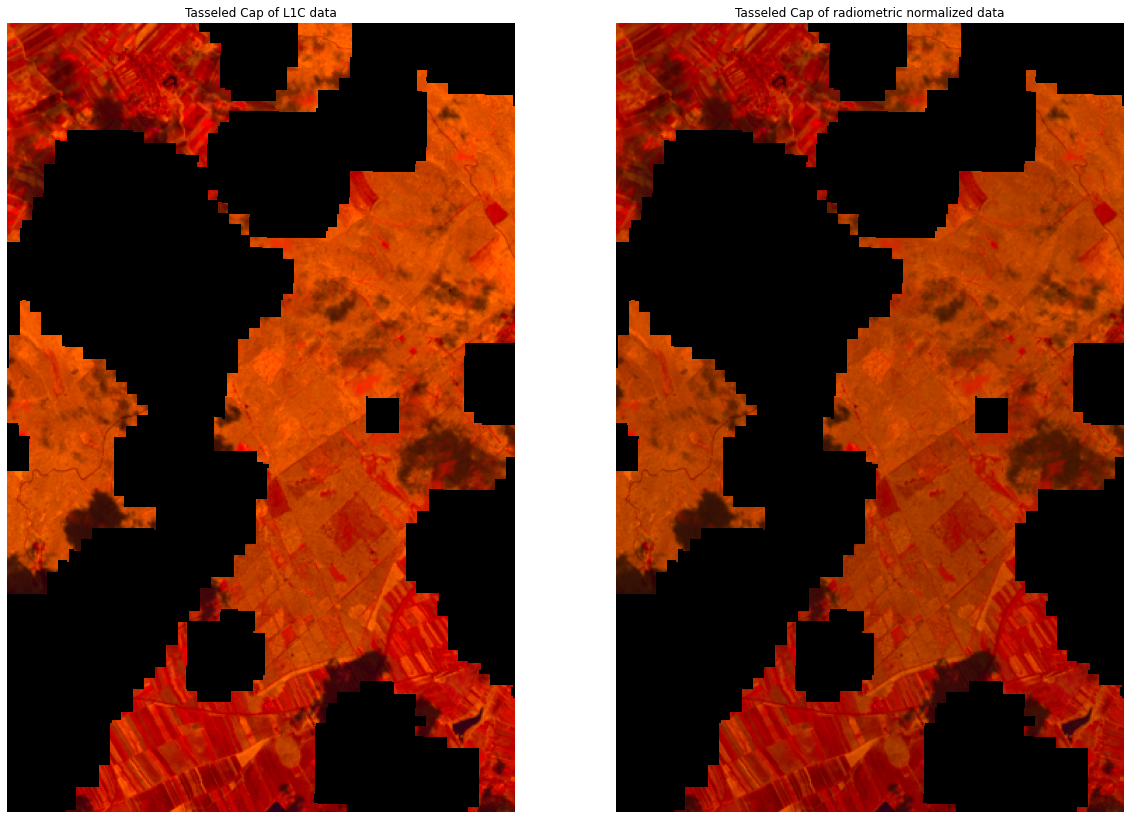

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,20))

ax = axs[0]
ax.imshow(np.clip(tasseled_cap_input, 0, 1))
ax.set_title("Tasseled Cap of L1C data")
ax.set_axis_off()

ax = axs[1]
ax.imshow(np.clip(tasseled_cap_output, 0, 1))
ax.set_title("Tasseled Cap of radiometric normalized data")
ax.set_axis_off()

By taking a closer look at the histograms of the Tasseled Cap Brightness values with L1C data (left) and radiometric normalized data (right) as the function input, a significant difference can be seen.

In [14]:
a = tasseled_cap_input[..., 0]
b = tasseled_cap_output[..., 0]

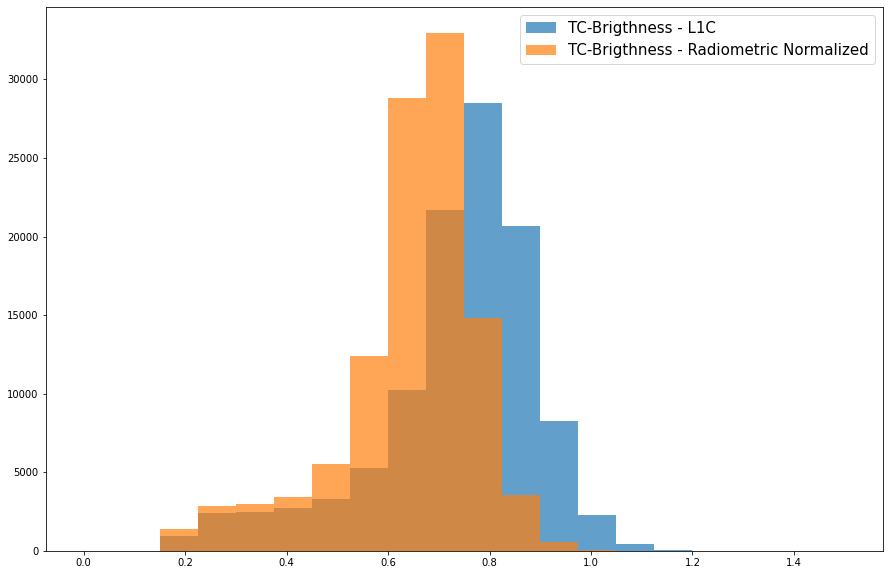

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))

ax.hist(tasseled_cap_input[..., 0].ravel(), 20, (0,1.5), alpha=0.7, label = "TC-Brigthness - L1C")
ax.hist(tasseled_cap_output[..., 0].ravel(), 20, (0,1.5), alpha=0.7, label = "TC-Brigthness - Radiometric Normalized");

plt.legend(fontsize=15);

Looking at the histogram of the reference composite (figure below), the distribution of the values is highest between 0.5 and 0.7. Thus, the normalization of the L1C data should have a similar value distribution which can be seen above.  Nevertheless, validating the effects of relative radiometric normalization is very challenging and would go beyond the scope of this demonstration.

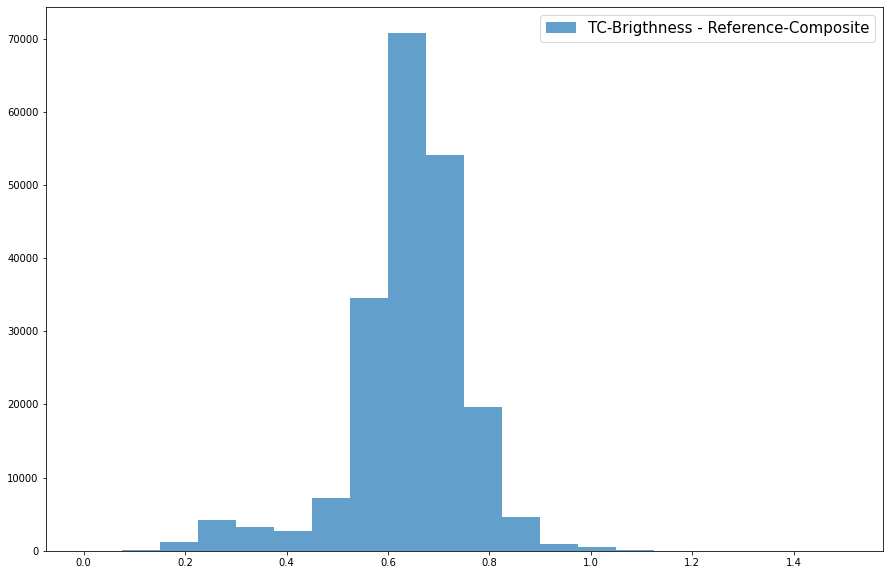

In [16]:
ref_comp = eop.data_timeless["REFERENCE_COMPOSITE"]
tasseled_cap_reference = tasseled_cap_index_for_sentinel2(ref_comp)

fig, ax = plt.subplots(figsize=(15,10))
ax.hist(tasseled_cap_reference[...,0].ravel(), 20, (0,1.5), alpha=0.7, label="TC-Brigthness - Reference-Composite")
plt.legend(fontsize=15)